# German Credit Rating

### Re-Indentification risk analysis and De-Indentification

In [1]:
import pandas as pd
from pyaaas import ARXaaS, Dataset, AttributeType

In [2]:
df = pd.read_csv("data/german_credit_data.csv")

In [3]:
df.dropna(inplace=True)
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
7,7,35,male,3,rent,little,moderate,6948,36,car,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


### Create Dataset and set attribute types

In [4]:
dataset = Dataset.from_pandas(df)

In [5]:
dataset.describe()

data:
  headers:
    ['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']
rows:
    [1, 22, 'female', 2, '...', 5951, 48, 'radio/TV', 'bad']
    [3, 45, 'male', 2, '...', 7882, 42, 'furniture/equipment', 'good']
    [4, 53, 'male', 2, '...', 4870, 24, 'car', 'bad']
    [7, 35, 'male', 3, '...', 6948, 36, 'car', 'good']
    [9, 28, 'male', 3, '...', 5234, 30, 'car', 'bad']
    ...
attributes:
  field_name=Unnamed: 0, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Age, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Sex, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Job, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Housing, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Saving accounts, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Checking account, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Credit amount, type=QUASIIDENTIFYING, hierarchy=None
  field_name=Duration, type=QU

In [6]:
dataset.set_attribute_type(AttributeType.INSENSITIVE, 'Unnamed: 0')
dataset.set_attribute_type(AttributeType.IDENTIFYING, 'Housing', 'Checking account', 'Duration', 'Purpose', 'Risk')

### Create RiskProfile

In [7]:
arxaas = ARXaaS("http://localhost:8080")

In [8]:
risk_profile = arxaas.risk_profile(dataset)

In [9]:
risk_profile.re_identification_risk

{'estimated_journalist_risk': 1.0,
 'records_affected_by_highest_prosecutor_risk': 1.0,
 'sample_uniques': 1.0,
 'lowest_risk': 1.0,
 'estimated_prosecutor_risk': 1.0,
 'highest_journalist_risk': 1.0,
 'records_affected_by_lowest_risk': 1.0,
 'average_prosecutor_risk': 1.0,
 'estimated_marketer_risk': 1.0,
 'highest_prosecutor_risk': 1.0,
 'records_affected_by_highest_journalist_risk': 1.0,
 'population_uniques': 1.0}

Estimated prosecutor risk is 1.0. The dataset re-Identification risk is high.

### Anonymize

#### Create hierarchies
Before we can attempt to anonymize the dataset we need to create generalization hierarchies for the quasiidentifying attributes.

In [10]:
from pyaaas.hierarchy import OrderHierarchyBuilder

##### Sex

In [11]:
ob = OrderHierarchyBuilder()

In [12]:
sexes = df["Sex"].unique().tolist()

In [13]:
sex_hierarchy = arxaas.hierarchy(ob, sexes)

In [14]:
sex_hierarchy

[['female', '*'], ['male', '*']]

#### Age

In [15]:
from pyaaas.hierarchy import IntervalHierarchyBuilder

In [16]:
ages = df["Age"].tolist()

In [17]:
iterval_builder = IntervalHierarchyBuilder()

In [18]:
iterval_builder.add_interval(0, 18, "child")
iterval_builder.add_interval(18, 30, "young-adult")
iterval_builder.add_interval(30, 60, "adult")
iterval_builder.add_interval(60, 120, "old")

In [19]:
iterval_builder.level(0).add_group(2, "young")
iterval_builder.level(0).add_group(2, "old")

Level(level=0, groups={Group(grouping=2, label=young): None, Group(grouping=2, label=old): None})

In [20]:
age_hierarchy = arxaas.hierarchy(iterval_builder, ages)

In [21]:
age_hierarchy[:10]

[['22', 'young-adult', 'young', '*'],
 ['45', 'adult', 'old', '*'],
 ['53', 'adult', 'old', '*'],
 ['35', 'adult', 'old', '*'],
 ['28', 'young-adult', 'young', '*'],
 ['25', 'young-adult', 'young', '*'],
 ['24', 'young-adult', 'young', '*'],
 ['22', 'young-adult', 'young', '*'],
 ['60', 'old', 'old', '*'],
 ['28', 'young-adult', 'young', '*']]

#### Credit amount

In [22]:
credit_amounts = df["Credit amount"].tolist()

In [23]:
df["Credit amount"].describe()

count      522.000000
mean      3278.745211
std       2929.155177
min        276.000000
25%       1297.500000
50%       2326.500000
75%       3971.250000
max      18424.000000
Name: Credit amount, dtype: float64

In [24]:
credit_interval = IntervalHierarchyBuilder()

In [25]:
credit_interval.add_interval(0, 1300, "low")
credit_interval.add_interval(1300, 2400, "medium")
credit_interval.add_interval(2400, 20000, "high")

credit_interval.level(0)\
    .add_group(2, "low-medium")\
    .add_group(2, "medium-high")


Level(level=0, groups={Group(grouping=2, label=low-medium): None, Group(grouping=2, label=medium-high): None})

In [26]:
credit_hierarchy = arxaas.hierarchy(credit_interval, credit_amounts)

In [27]:
credit_hierarchy[:10]

[['5951', 'high', 'medium-high', '*'],
 ['7882', 'high', 'medium-high', '*'],
 ['4870', 'high', 'medium-high', '*'],
 ['6948', 'high', 'medium-high', '*'],
 ['5234', 'high', 'medium-high', '*'],
 ['1295', 'low', 'low-medium', '*'],
 ['4308', 'high', 'medium-high', '*'],
 ['1567', 'medium', 'low-medium', '*'],
 ['1199', 'low', 'low-medium', '*'],
 ['1403', 'medium', 'low-medium', '*']]

#### Job

In [28]:
jobs = df["Job"].tolist()

In [29]:
df["Job"].describe()

count    522.000000
mean       1.875479
std        0.682811
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: Job, dtype: float64

In [30]:
job_interval = IntervalHierarchyBuilder()

In [31]:
job_interval.add_interval(0,1,"un-employed")
job_interval.add_interval(1,4,"employed")

In [32]:
job_hierarchy = arxaas.hierarchy(job_interval, jobs)

In [33]:
job_hierarchy[:10]

[['2', 'employed', '*'],
 ['2', 'employed', '*'],
 ['2', 'employed', '*'],
 ['3', 'employed', '*'],
 ['3', 'employed', '*'],
 ['2', 'employed', '*'],
 ['2', 'employed', '*'],
 ['2', 'employed', '*'],
 ['1', 'employed', '*'],
 ['2', 'employed', '*']]

#### Set hierarchies

In [34]:
dataset.set_hierarchy("Sex", sex_hierarchy)
dataset.set_hierarchy("Age", age_hierarchy)
dataset.set_hierarchy("Credit amount", credit_hierarchy)
dataset.set_hierarchy("Job", job_hierarchy)

In [35]:
from pyaaas.privacy_models import KAnonymity

In [36]:
kanon = KAnonymity(2)

### Attempt anonymization

In [37]:
anon_result = arxaas.anonymize(dataset, [kanon])

In [38]:
anon_result.dataset.to_dataframe().head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,1,*,female,*,*,little,*,medium-high,*,*,*
1,3,*,male,*,*,little,*,medium-high,*,*,*
2,4,*,male,*,*,little,*,medium-high,*,*,*
3,7,*,male,*,*,little,*,medium-high,*,*,*
4,9,*,male,*,*,little,*,medium-high,*,*,*


#### Hierarchy level applied

In [39]:
anon_metrics = anon_result.anonymization_metrics

In [40]:
anon_metrics.attribute_generalization

[{'name': 'Age',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 3},
 {'name': 'Sex',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 0},
 {'name': 'Job',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 2},
 {'name': 'Saving accounts',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 0},
 {'name': 'Credit amount',
  'type': 'QUASI_IDENTIFYING_ATTRIBUTE',
  'generalizationLevel': 2}]

### New re-identification risk

In [41]:
anon_risk_profile = anon_result.risk_profile

In [42]:
anon_risk_profile.re_identification_risk

{'estimated_journalist_risk': 0.3333333333333333,
 'records_affected_by_highest_prosecutor_risk': 0.011494252873563218,
 'sample_uniques': 0.0,
 'lowest_risk': 0.0070921985815602835,
 'estimated_prosecutor_risk': 0.3333333333333333,
 'highest_journalist_risk': 0.3333333333333333,
 'records_affected_by_lowest_risk': 0.5344827586206897,
 'average_prosecutor_risk': 0.03065134099616858,
 'estimated_marketer_risk': 0.03065134099616858,
 'highest_prosecutor_risk': 0.3333333333333333,
 'records_affected_by_highest_journalist_risk': 0.011494252873563218,
 'population_uniques': 0.0}

In [43]:
before_risk = risk_profile.re_identification_risk_dataframe()[['estimated_prosecutor_risk', 'highest_prosecutor_risk', 'lowest_risk']].copy()
before_risk["from"] = "before"

In [44]:
after_risk = anon_risk_profile.re_identification_risk_dataframe()[['estimated_prosecutor_risk', 'highest_prosecutor_risk', 'lowest_risk']].copy()
after_risk["from"] = "after"

In [45]:
risks_df = pd.concat([before_risk, after_risk])

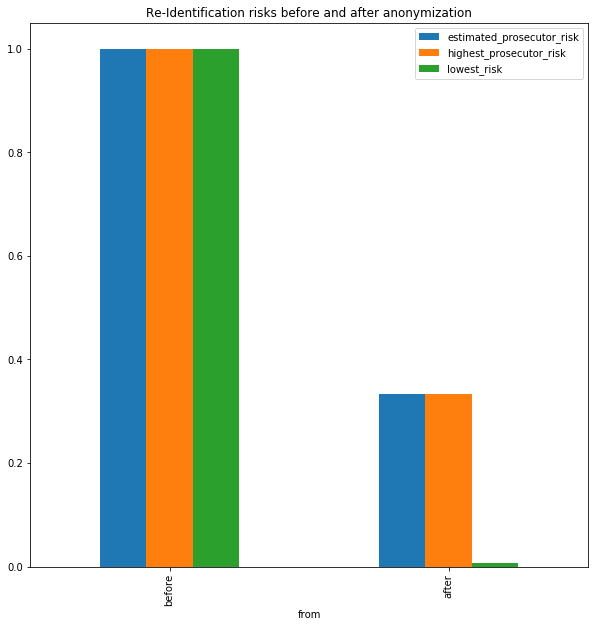

In [47]:
risks_df.plot(kind="bar", x="from", title="Re-Identification risks before and after anonymization", figsize=(10, 10));